<a href="https://colab.research.google.com/github/1boge/my_repos/blob/master/1_decision_trees_afan_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.1. Деревья решений. Классификация

### План

* критерий информативности
* визуализация разделяющих поверхностей решения и визуализация самого дерева
* оценка важности фичей
* ужасы переобучения

## 1. Критерий информативности

как мы разобрали, построение дерева зависит от следующих факторов:
* вид правила разбиения
* критерий информативности
* критерий останова
* метод стрижки
* проблема пропусков

пройдёмся по критериям информативности

In [2]:
import numpy as np
from collections import Counter
import pandas as pd # Для работы с данными
import scipy.stats # При работе со статистикой
import matplotlib.pyplot as plt  # Библиотека для визуализации результатов
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import random
from sklearn.linear_model import LogisticRegression

*Нам понадобятся две библиотеки: numpy вы знаете, а объект класса Counter в заданном списке просто подсчитывает количество вхождений каждого элемента и возвращает результат в виде словаря. Пример:*

In [ ]:
Counter([9,9,9,7,7])

Counter({7: 2, 9: 3})

*Для численного измерения улучшения разбиений на каждом этапе мы вводим некоторый *критерий информативности*, который будет оценивать разнообразие объектов в выборке: чем больше разных классов в выборке, тем больше значение H(R). Чем меньше взвешенное значение критерия после разбиения - тем лучше*

Ниже представлена функция для расчёта энтропийного критерия качества:

$H(R) = -\sum_{k=1}^{K}p_klogp_k$

**Задание.** Дополните функцию расчёта энтропийного критерия множества

$Н(R) = -\sum_{k=1}^{K}p_klog(p_k)$

In [3]:
def HEntropy(l):
    length = len(l)
    cnt = Counter(l)
    
    ent = 0
    for cl in cnt.values():
        p = cl / length
        l2 = np.log2(p)
        it = -p * l2
        ent += it
    
    return ent

**Задание.** По аналогии с *энтропийным критерием* заполните функции *критерия Джини*

$Н(R) = \sum_{k=1}^{K}p_k(1-p_k)$

In [4]:
def HGini(l):
    length = len(l)
    cnt = Counter(l)
    
    gini = 0
    for cl in cnt.values():
        p_1 = cl / length
        p_2 = (1 - p_1)
        it = p_1 * p_2
        gini += it
    
    return gini

*Information Gain (IG)* - функционал качества, отвечающий на вопрос, а сколько энтропии мы погасили при определённом разбиении? На каждом шаге разбиения при построении дерева максимизируется IG. Формула для вычисления при критерии информативности H:

$IG(R) = H(R) - \frac{|R_l|}{|R|}H(R_l) - \frac{|R_r|}{|R|}H(R_r)$

**Задание.** Заполните функцию для вычисления функционала качества

In [5]:
def IG(H, l, i):
    left_l = l[:i]
    right_l = l[i:]
    return H(l) - (len(left_l) / len(l)) * H(left_l) - (len(right_l) / len(l)) * H(right_l)

Тут функция для визуализации работы произвольного критерия качества на выборке

In [6]:
def test_H(H, l):
    print("{:5} {:3}   {:4} {:4} {:4}".format("#","l","IG","Hl","Hr"))
    print("-"*24)
    i_max,IG_max=0,0
    for i in range(0,len(l)):
        print(f"{i:2}. {l[i]:3}   {IG(H, l, i):.2f} {H(l[:i]):.2f} {H(l[i:]):.2f}")
        if IG_max < IG(H, l, i):
            i_max, IG_max = i, IG(H, l, i)
    print(f'Деление после элемента:{i_max-1}')

Определим как-нибудь выборку и посмотрим, какое разбиение предложат критерии информативности. Замечу, что элементы здесь будут выводиться начиная со второго, а значения функций рассчитаны для разбиения *перед* элементом строки

In [ ]:
#l = [1]*5 + [2]*3 + [1]*4

In [7]:
import warnings
from sklearn.datasets import load_boston
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X,l = load_boston(return_X_y=True)
print(X.shape)

(506, 13)


In [8]:
test_H(HEntropy, l)

#     l     IG   Hl   Hr  
------------------------
 0. 24.0   0.00 0.00 7.53
 1. 21.6   0.02 0.00 7.53
 2. 34.7   0.03 1.00 7.52
 3. 33.4   0.04 1.58 7.52
 4. 36.2   0.05 2.00 7.52
 5. 28.7   0.06 2.32 7.51
 6. 22.9   0.07 2.58 7.51
 7. 27.1   0.08 2.81 7.51
 8. 16.5   0.09 3.00 7.51
 9. 18.9   0.09 3.17 7.51
10. 15.0   0.10 3.32 7.51
11. 18.9   0.10 3.46 7.51
12. 21.7   0.11 3.42 7.51
13. 20.4   0.12 3.55 7.51
14. 18.2   0.12 3.66 7.51
15. 19.9   0.12 3.77 7.51
16. 23.1   0.13 3.88 7.52
17. 17.5   0.13 3.97 7.52
18. 20.2   0.13 4.06 7.52
19. 18.2   0.14 4.14 7.52
20. 13.6   0.15 4.12 7.51
21. 19.6   0.15 4.20 7.51
22. 15.2   0.15 4.28 7.51
23. 14.5   0.16 4.35 7.51
24. 15.6   0.16 4.42 7.51
25. 13.9   0.16 4.48 7.52
26. 16.6   0.17 4.55 7.51
27. 14.8   0.17 4.61 7.51
28. 18.4   0.18 4.66 7.51
29. 21.0   0.18 4.72 7.51
30. 12.7   0.18 4.77 7.51
31. 14.5   0.19 4.83 7.51
32. 13.2   0.19 4.81 7.50
33. 13.1   0.20 4.86 7.50
34. 13.5   0.20 4.91 7.50
35. 18.9   0.21 4.96 7.50
36. 20.0   0

In [9]:
test_H(HGini, l)

#     l     IG   Hl   Hr  
------------------------
 0. 24.0   0.00 0.00 0.99
 1. 21.6   0.00 0.00 0.99
 2. 34.7   0.00 0.50 0.99
 3. 33.4   0.00 0.67 0.99
 4. 36.2   0.00 0.75 0.99
 5. 28.7   0.00 0.80 0.99
 6. 22.9   0.00 0.83 0.99
 7. 27.1   0.00 0.86 0.99
 8. 16.5   0.00 0.88 0.99
 9. 18.9   0.00 0.89 0.99
10. 15.0   0.00 0.90 0.99
11. 18.9   0.00 0.91 0.99
12. 21.7   0.00 0.90 0.99
13. 20.4   0.00 0.91 0.99
14. 18.2   0.00 0.92 0.99
15. 19.9   0.00 0.92 0.99
16. 23.1   0.00 0.93 0.99
17. 17.5   0.00 0.93 0.99
18. 20.2   0.00 0.94 0.99
19. 18.2   0.00 0.94 0.99
20. 13.6   0.00 0.94 0.99
21. 19.6   0.00 0.94 0.99
22. 15.2   0.00 0.95 0.99
23. 14.5   0.00 0.95 0.99
24. 15.6   0.00 0.95 0.99
25. 13.9   0.00 0.95 0.99
26. 16.6   0.00 0.96 0.99
27. 14.8   0.00 0.96 0.99
28. 18.4   0.00 0.96 0.99
29. 21.0   0.00 0.96 0.99
30. 12.7   0.00 0.96 0.99
31. 14.5   0.00 0.96 0.99
32. 13.2   0.00 0.96 0.99
33. 13.1   0.00 0.96 0.99
34. 13.5   0.00 0.97 0.99
35. 18.9   0.00 0.97 0.99
36. 20.0   0

**Задание.** проверьте, какое разбиение будет сделано на втором шаге?

In [10]:
test_H(HGini, l[5:])

#     l     IG   Hl   Hr  
------------------------
 0. 28.7   0.00 0.00 0.99
 1. 22.9   0.00 0.00 0.99
 2. 27.1   0.00 0.50 0.99
 3. 16.5   0.00 0.67 0.99
 4. 18.9   0.00 0.75 0.99
 5. 15.0   0.00 0.80 0.99
 6. 18.9   0.00 0.83 0.99
 7. 21.7   0.00 0.82 0.99
 8. 20.4   0.00 0.84 0.99
 9. 18.2   0.00 0.86 0.99
10. 19.9   0.00 0.88 0.99
11. 23.1   0.00 0.89 0.99
12. 17.5   0.00 0.90 0.99
13. 20.2   0.00 0.91 0.99
14. 18.2   0.00 0.92 0.99
15. 13.6   0.00 0.92 0.99
16. 19.6   0.00 0.92 0.99
17. 15.2   0.00 0.93 0.99
18. 14.5   0.00 0.93 0.99
19. 15.6   0.00 0.94 0.99
20. 13.9   0.00 0.94 0.99
21. 16.6   0.00 0.94 0.99
22. 14.8   0.00 0.95 0.99
23. 18.4   0.00 0.95 0.99
24. 21.0   0.00 0.95 0.99
25. 12.7   0.00 0.95 0.99
26. 14.5   0.00 0.96 0.99
27. 13.2   0.00 0.95 0.99
28. 13.1   0.00 0.96 0.99
29. 13.5   0.00 0.96 0.99
30. 18.9   0.00 0.96 0.99
31. 20.0   0.00 0.96 0.99
32. 21.0   0.00 0.96 0.99
33. 24.7   0.00 0.96 0.99
34. 30.8   0.00 0.96 0.99
35. 34.9   0.00 0.96 0.99
36. 26.6   0

In [11]:
boston = load_boston()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [12]:
#data_url = "http://lib.stat.cmu.edu/datasets/boston"
#raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
#data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
#target = raw_df.values[1::2, 2]
random.seed(42)
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [13]:
df['TAX'].unique()

array([296., 242., 222., 311., 307., 279., 252., 233., 243., 469., 226.,
       313., 256., 284., 216., 337., 345., 305., 398., 281., 247., 270.,
       276., 384., 432., 188., 437., 403., 193., 265., 255., 329., 402.,
       348., 224., 277., 300., 330., 315., 244., 264., 223., 254., 198.,
       285., 241., 293., 245., 289., 358., 304., 287., 430., 422., 370.,
       352., 351., 280., 335., 411., 187., 334., 666., 711., 391., 273.])

In [14]:
selectedColumns = df [['CRIM', 'TAX','DIS','AGE']]
X = pd.get_dummies (selectedColumns, columns = ['TAX'])

print('Пометили статус единичкой.')
X.head()

Пометили статус единичкой.


,CRIM,DIS,AGE,TAX_187.0,TAX_188.0,TAX_193.0,TAX_198.0,TAX_216.0,TAX_222.0,TAX_223.0,TAX_224.0,TAX_226.0,TAX_233.0,TAX_241.0,TAX_242.0,TAX_243.0,TAX_244.0,TAX_245.0,TAX_247.0,TAX_252.0,TAX_254.0,TAX_255.0,TAX_256.0,TAX_264.0,TAX_265.0,TAX_270.0,TAX_273.0,TAX_276.0,TAX_277.0,TAX_279.0,TAX_280.0,TAX_281.0,TAX_284.0,TAX_285.0,TAX_287.0,TAX_289.0,TAX_293.0,TAX_296.0,TAX_300.0,TAX_304.0,TAX_305.0,TAX_307.0,TAX_311.0,TAX_313.0,TAX_315.0,TAX_329.0,TAX_330.0,TAX_334.0,TAX_335.0,TAX_337.0,TAX_345.0,TAX_348.0,TAX_351.0,TAX_352.0,TAX_358.0,TAX_370.0,TAX_384.0,TAX_391.0,TAX_398.0,TAX_402.0,TAX_403.0,TAX_411.0,TAX_422.0,TAX_430.0,TAX_432.0,TAX_437.0,TAX_469.0,TAX_666.0,TAX_711.0
0,0.00632,4.0900,65.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.02731,4.9671,78.9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.02729,4.9671,61.1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.03237,6.0622,45.8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.06905,6.0622,54.2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [16]:
le.fit( df['TAX'])

LabelEncoder()

In [17]:
y = pd.Series (df['TAX'])
y.head()

0    296.0
1    242.0
2    242.0
3    222.0
4    222.0
Name: TAX, dtype: float64

In [18]:
from sklearn.pipeline import make_pipeline # используем пайплайны для удобства
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [21]:
model.score(X_train, y_train) 

1.0

In [22]:
model.score(X_test,y_test)

0.9671052631578947

In [23]:
# обучаем на части датасета (train)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [24]:
predictions[:10] # посмотрим как выглядят наши предсказания

array([296., 254., 711., 305., 666., 398., 304., 437., 666., 391.])

-----

## 3. DecisionTreeRegressor

In [34]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [35]:
X, y = boston['data'], boston['target']

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [37]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

In [38]:
tree_reg = DecisionTreeRegressor()

In [39]:
tree_params = {
    'max_depth': range(1, 11),
    'splitter': ['best', 'random'],
    'criterion': ['mse', 'mae', 'friedman_mse'],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}
grid_tree = GridSearchCV(tree_reg, tree_params, cv=10, verbose=2, n_jobs=-1)
grid_tree.fit(X_train, y_train)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae', 'friedman_mse'],
                         'max_depth': range(1, 11),
                         'min_samples_leaf': [1, 2, 4, 8, 16],
                         'splitter': ['best', 'random']},
             verbose=2)

In [40]:
print(grid_tree.best_params_)
print(grid_tree.best_score_)
print(grid_tree.best_estimator_)

{'criterion': 'mae', 'max_depth': 5, 'min_samples_leaf': 1, 'splitter': 'best'}
0.7789220908172947
DecisionTreeRegressor(criterion='mae', max_depth=5)


NameError: ignored

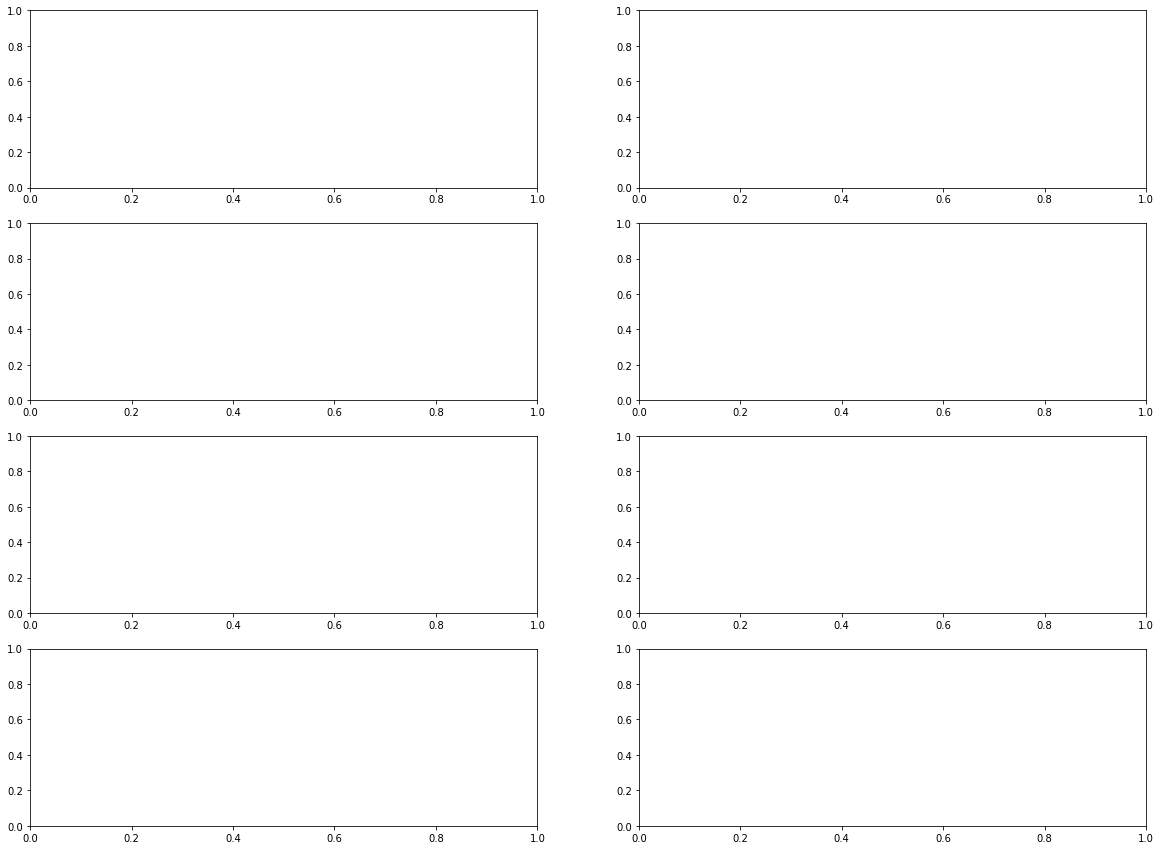

In [41]:
# Plot the results

fig, axa = plt.subplots(4,2, figsize=(20,15))
for i, (key , cur_pred) in enumerate(pred_list.items()):
    ax = axa[i//2,i%2]
    ax.scatter(X, y, s=20, edgecolor="black",c="darkorange", label="data")
    ax.plot(X_test, cur_pred,label=f"{key}", linewidth=2)
    ax.grid()
    ax.legend()

fig.suptitle("Decision Tree Regression")
plt.show()